In [1]:
import matplotlib.pyplot as plt
import numpy as np
import healpy as hp
from healpy import projview
from icecube_tools.utils.data import RealEvents, SimEvents
from icecube_tools.point_source_analysis.point_source_analysis import MapScan, MapScanTSDistribution
import h5py
from scipy.stats import ncx2, chi2

## Idea to parallelise in a sensible fashion

Set npix/nside to the desired angular resolution and generate sources. Split sources into reasonable length parts, e.g. 1000 sources, meaning `MapScan().test_ra = MapScan().test_ra[n*1000:(n+1)*1000]`. Then write config with distinct name. Repeat until all sources are in mentioned in a config.

Read in configs in parallel processes, calculate, write output again with same distinct identifier.

Make script reading in all result files.

In [2]:
events = RealEvents.from_event_files()

Resetting rng


In [3]:
scan = MapScan("config.yaml", events, "skymap_ngc_restricted_updated_dec.hdf5")

In [4]:
events.periods

['IC40', 'IC59', 'IC79', 'IC86_I', 'IC86_II']

In [5]:
r = np.deg2rad(np.linspace(38, 42, num=11))
d = np.deg2rad(np.linspace(-2, 2, num=11))
rr, dd = np.meshgrid(r, d)
rr = rr.flatten()
dd = dd.flatten()
print(rr.size)

121


In [6]:
scan.ra_test = rr
scan.dec_test = dd
scan.generate_sources(nside=False)
scan.ts.shape

(121,)

In [7]:
scan.perform_scan(show_progress=True)

  0%|          | 0/121 [00:00<?, ?it/s]/home/iwsatlas1/kuhlmann/icecube/icecube_tools/icecube_tools/detector/r2021.py:82: RuntimeWarning: divide by zero encountered in log10
  self.dataset[:, 6:-1] = np.log10(self.dataset[:, 6:-1])
/home/iwsatlas1/kuhlmann/icecube/icecube_tools/icecube_tools/detector/r2021.py:82: RuntimeWarning: divide by zero encountered in log10
  self.dataset[:, 6:-1] = np.log10(self.dataset[:, 6:-1])
/home/iwsatlas1/kuhlmann/icecube/icecube_tools/icecube_tools/detector/r2021.py:82: RuntimeWarning: divide by zero encountered in log10
  self.dataset[:, 6:-1] = np.log10(self.dataset[:, 6:-1])
/home/iwsatlas1/kuhlmann/icecube/icecube_tools/icecube_tools/detector/r2021.py:82: RuntimeWarning: divide by zero encountered in log10
  self.dataset[:, 6:-1] = np.log10(self.dataset[:, 6:-1])
100%|██████████| 121/121 [04:09<00:00,  2.06s/it]


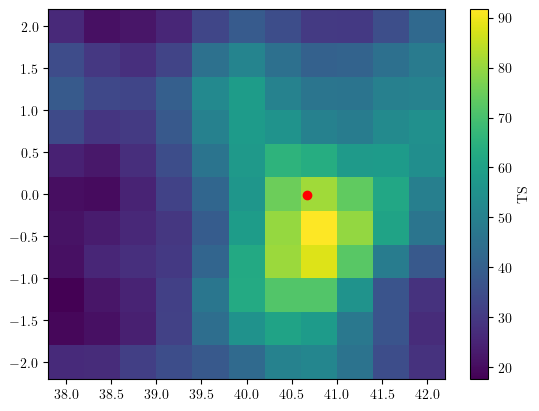

In [13]:
fig, ax = plt.subplots()
pcol = ax.pcolormesh(np.rad2deg(r), np.rad2deg(d), scan.ts.reshape((11, 11)), shading="nearest")
fig.colorbar(pcol, ax=ax, label='TS')
ax.scatter(40.6696215289200, -00.0132943583900, c="red")

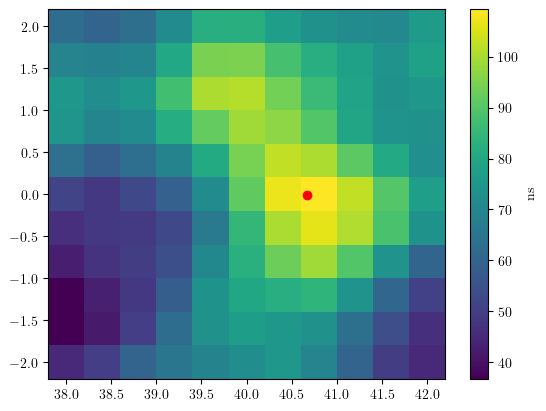

In [11]:
fig, ax = plt.subplots()
pcol = ax.pcolormesh(np.rad2deg(r), np.rad2deg(d), scan.ns.reshape((11, 11)), shading="nearest")
fig.colorbar(pcol, ax=ax, label='ns')
ax.scatter(40.6696215289200, -00.0132943583900, c="red")

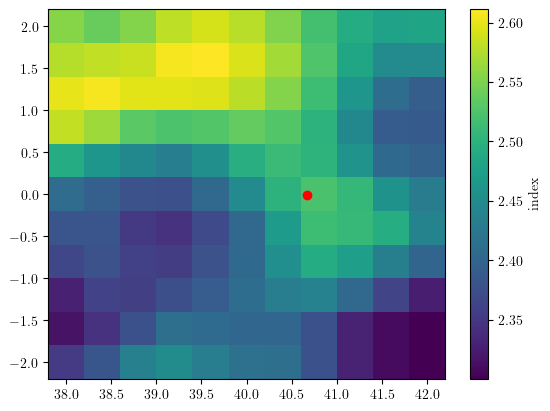

In [12]:
fig, ax = plt.subplots()
pcol = ax.pcolormesh(np.rad2deg(r), np.rad2deg(d), scan.index.reshape((11, 11)), shading="nearest")
fig.colorbar(pcol, ax=ax, label='index')
ax.scatter(40.6696215289200, -00.0132943583900, c="red")

## Create TS distribution
TS values themselves are not calibrated, we need to "simulate" (i.e. for a large enough data set shuffle the RAs to wash out any source associations) lots of events, fit again a source and find the TS. From the number of simulated data sets with TS larger than the one from the un-shuffled data we obtain the local p-value.

Since the declination-dependency is given by the declination dependency of the effective area, it is sufficient to create TS distributions only once for each aeff's declination bin.

In [3]:
ts_dist = MapScanTSDistribution("config.yaml", events, "ts_dist")

In [4]:
ts_dist.ra_test = np.array([np.pi])
ts_dist.dec_test = np.array([np.deg2rad(-0.3)])
ts_dist.ntrials=1000

In [5]:
ts_dist.generate_sources(nside=False)

In [6]:
ts_dist.ts.shape

(1000,)

In [7]:
ts_dist.perform_scan(show_progress=True)

  0%|          | 0/1000 [00:00<?, ?it/s]INFO:icecube_tools.utils.data:Scrambling RAs.
/home/iwsatlas1/kuhlmann/icecube/icecube_tools/icecube_tools/detector/r2021.py:82: RuntimeWarning: divide by zero encountered in log10
  self.dataset[:, 6:-1] = np.log10(self.dataset[:, 6:-1])
/home/iwsatlas1/kuhlmann/icecube/icecube_tools/icecube_tools/detector/r2021.py:82: RuntimeWarning: divide by zero encountered in log10
  self.dataset[:, 6:-1] = np.log10(self.dataset[:, 6:-1])
/home/iwsatlas1/kuhlmann/icecube/icecube_tools/icecube_tools/detector/r2021.py:82: RuntimeWarning: divide by zero encountered in log10
  self.dataset[:, 6:-1] = np.log10(self.dataset[:, 6:-1])
/home/iwsatlas1/kuhlmann/icecube/icecube_tools/icecube_tools/detector/r2021.py:82: RuntimeWarning: divide by zero encountered in log10
  self.dataset[:, 6:-1] = np.log10(self.dataset[:, 6:-1])
  5%|▍         | 48/1000 [01:47<33:29,  2.11s/it]INFO:icecube_tools.utils.data:Scrambling RAs.
/home/iwsatlas1/kuhlmann/icecube/icecube_tools/

In [9]:
ts_copy = ts_dist.ts.copy()

In [10]:
ts_copy.sort()

(19.38652689983675, -12.488199677007419, 2.0497765370354397)


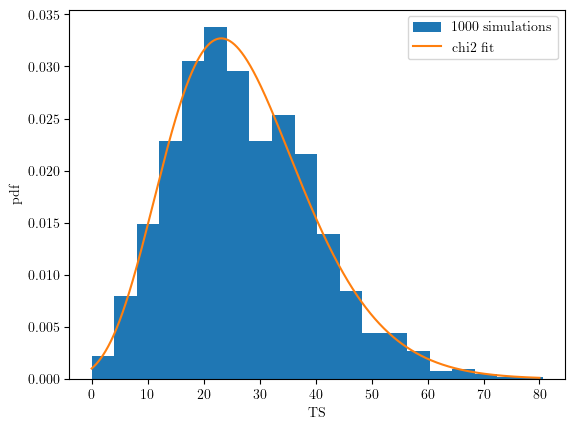

In [35]:
plt.hist(ts_copy, bins=20, density=True, label="1000 simulations")
pars = chi2.fit(ts_copy)
x = np.linspace(0, 80, num=1000)
plt.plot(x, chi2(*pars).pdf(x), label="chi2 fit")
plt.xlabel("TS")
plt.ylabel("pdf")
plt.legend()
print(pars)

(0.7595292276028456,
 4.432157257913266,
 -3.879248207945769e-05,
 4.323925756956557)

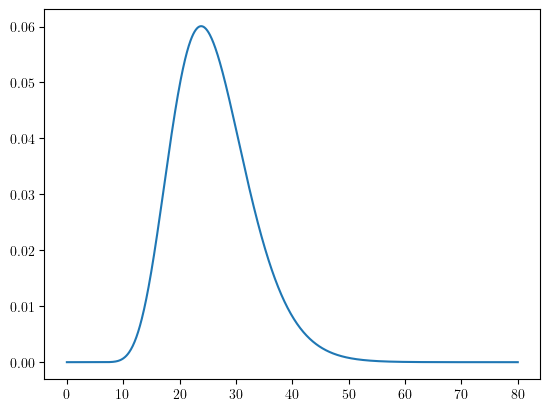

In [30]:
plt.plot(x, ncx2.pdf(x, 20, 2, 4))
pars

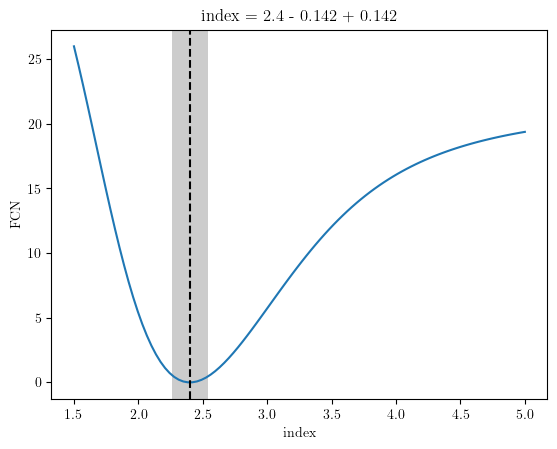

In [17]:
_ = ts_dist.likelihood.m.draw_profile("index", bound=(1.5, 5.))

In [34]:
ra = ts_dist.events.ra["IC86_II"]
ra

array([3.5505233 , 0.03516838, 2.07352096, ..., 4.30843253, 2.47304428,
       0.2515194 ])

In [33]:
events.scramble_ra()

In [11]:
ts_dist.events.scramble_ra()
ts_dist.events.ra

{'IC40': array([1.81835362, 4.48390776, 5.24077023, ..., 3.97811747, 5.31786731,
        3.07006558]),
 'IC59': array([4.04948393, 4.98648525, 2.91034418, ..., 5.31187006, 1.34930074,
        6.15193868]),
 'IC79': array([2.51661361, 6.15572336, 6.15695506, ..., 2.58342438, 2.09964587,
        5.52301091]),
 'IC86_I': array([0.75806439, 3.19002761, 2.40923003, ..., 2.29057391, 2.37687205,
        3.78525956]),
 'IC86_II': array([4.02581882, 6.01140161, 3.81423145, ..., 1.59710914, 5.81362048,
        0.15723492])}

In [12]:
ts_dist.events.dec

{'IC40': array([ 0.29251718, -0.23336797,  0.19704767, ..., -1.21982807,
         0.59908427,  0.53635713]),
 'IC59': array([ 0.92624623,  0.03036873, -0.42776275, ...,  0.4807684 ,
        -0.02073451,  0.28167869]),
 'IC79': array([-0.36564648, -0.01336922, -0.60000929, ..., -0.23001694,
         0.41776201,  0.18338174]),
 'IC86_I': array([-0.3948982 ,  0.68259827,  0.08201302, ...,  0.90237013,
         0.64652231,  1.17118574]),
 'IC86_II': array([-0.99286545,  0.02396337,  0.15282103, ...,  0.74251542,
         0.78051124,  0.0821701 ])}